In [ ]:
# %pip install numpy matplotlib oasis-deconv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oasis.functions import deconvolve

c:\Users\sange\anaconda3\envs\s2p\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [11]:
traces = np.load("data/F.npy")
cal_traces = []
dtraces = []

for i, trace in enumerate(traces):
    F = trace.copy()
    F0 = np.median(F)
    cal_trace = (F - F0) / abs(F0)
    try:
        _, dt, _, _, _ = deconvolve(cal_trace)
        cal_traces.append(cal_trace)
        dtraces.append(dt)
    except:
        continue

C:\Users\sange\AppData\Local\Temp\ipykernel_18424\3552383840.py:8: RuntimeWarning: invalid value encountered in divide
  cal_trace = (F - F0) / abs(F0)


In [37]:
ind = 11
trace = cal_traces[ind].copy()
dtrace = dtraces[ind].copy()

# Thresholding and Events: Converting Continuous Calcium Traces into Discrete Event Times

In this module, we will analyze the deconvolved output of calcium imaging data to extract discrete neural events. The deconvolved signal, inferred using the OASIS algorithm, provides a continuous estimate of spiking activity over time. However, this signal includes small amplitude fluctuations that may not reflect actual spikes. To interpret this signal meaningfully, we must detect and extract the time points at which neurons were most likely active. This notebook guides you through this process, starting with thresholding the deconvolved signal, identifying event onsets, and ending with the computation of firing rate traces.


## Understanding and Thresholding the Deconvolved Signal

The deconvolved signal returned by OASIS is sparse but continuous. While many values are close to zero, not all non-zero points correspond to real spike events. In this section, we will inspect the deconvolved traces from selected neurons and apply amplitude thresholding to isolate frames with significant spiking activity. This step filters out low-amplitude noise and prepares the signal for event detection.

When thresholding the deconvolved signal, your goal is to keep sharp, isolated peaks while ignoring small background fluctuations. 

To begin, we try a simple manual threshold. This helps us visually check which parts of the deconvolved trace are above a chosen cutoff. We are not detecting events yet. We are just seeing where the signal exceeds a fixed value.

**Example** Plot the deconvolved trace. Add a line at 0.15.

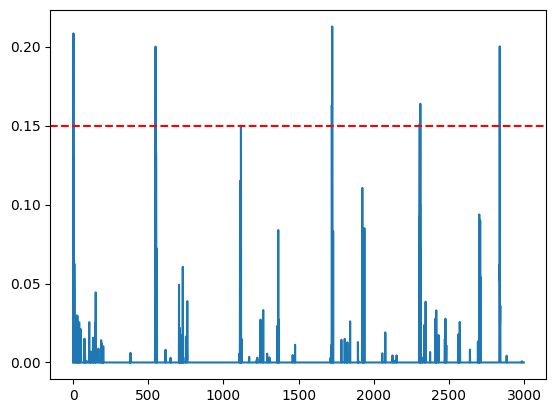

In [41]:
plt.plot(dtrace)
plt.axhline(0.15, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.0001.

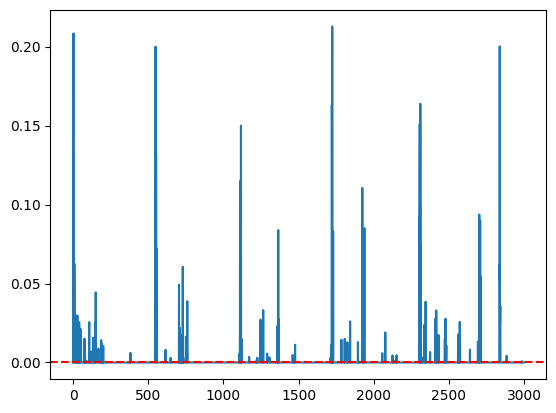

In [42]:
plt.plot(dtrace)
plt.axhline(0.0001, color='r', linestyle='--');

Plot the deconvolved trace. Set y-axis to (0, 0.01). Add a line at 0.00001.

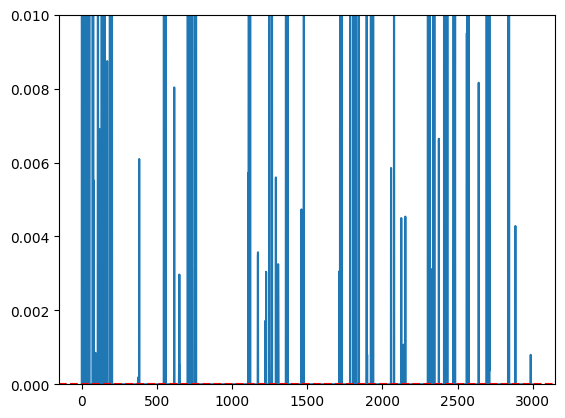

In [47]:
plt.plot(dtrace)
plt.ylim(0.00, 0.01)
plt.axhline(0.00001, color='r', linestyle='--');

Plot the deconvolved trace. Add a line at 0.002.

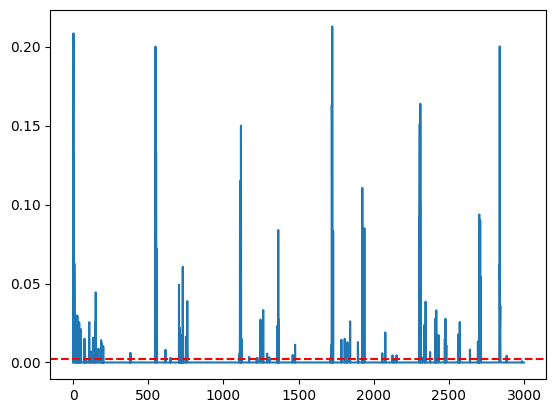

In [49]:
plt.plot(dtrace)
plt.axhline(0.002, color='r', linestyle='--');

Now we apply the threshold to the deconvolved signal and count how many frames are above it. This gives us a rough idea of how active the neuron appears, based on the chosen threshold.

**Example** Set threshold to 0.15. Count how many values in the deconvolved trace are above this threshold.

In [50]:
np.sum(dtrace > 0.15)

np.int64(7)

Set threshold to 0.002. Count how many values are above this threshold.

In [51]:
np.sum(dtrace > 0.002)

np.int64(137)

Set threshold to 0.00001. Count how many values are above this threshold.

In [52]:
np.sum(dtrace > 0.00001)

np.int64(160)

Instead of choosing a threshold manually, we can use a data-driven rule: mean + 2 × standard deviation. This sets the threshold relative to the baseline and variability in the signal. We then count how many frames exceed this automatic threshold.

Automatic thresholds depend on both the baseline (mean or median) and the spread (standard deviation) of the deconvolved signal. By trying different combinations, we can begin to choose thresholds that are sensitive to strong activity, while ignoring low-level noise.

**Example** Set threshold to mean + 10 × std. Count how many values are above this threshold.

In [53]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 10 * sigma
np.sum(dtrace > auto_thresh)

np.int64(9)

Set threshold to mean + 5 × std. Count how many values are above this threshold.

In [59]:
mu = np.mean(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 5 * sigma
np.sum(dtrace > auto_thresh)

np.int64(31)

Set threshold to median + 2 × std. Count how many values are above this threshold.

In [58]:
mu = np.median(dtrace)
sigma = np.std(dtrace)
auto_thresh = mu + 2.0 * sigma
np.sum(dtrace > auto_thresh)

np.int64(57)


## Identifying Spike Times from Thresholded Signal

After thresholding, we need to convert the resulting sparse vector into a list of distinct spike times. Instead of treating every suprathreshold frame as a separate spike, we will detect the onset of each spike event. This is done by identifying transitions in the thresholded signal and mapping them to time using the recording’s frame rate.

**Creating binary vector of events**

Create a binary array where `1` means above threshold and `0` means below

In [ ]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
np.diff(is_active.astype(int))[:25]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0])

In [99]:
treshold_factor = 3.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
np.diff(is_active.astype(int))[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [102]:
treshold_factor = 0.5
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
np.diff(is_active.astype(int))[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

**Detect rising edges**

Event onset can be identified based on when the mask changes from `0` to `1`

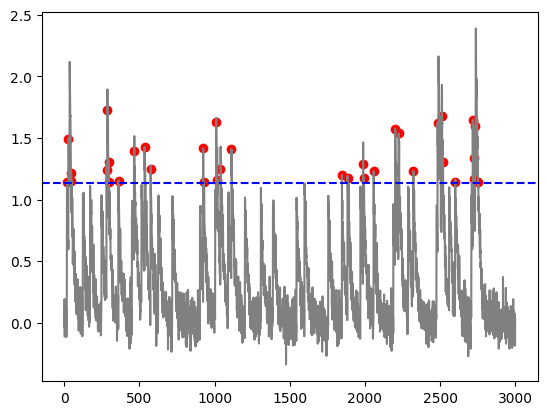

In [ ]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_1, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_1))[onset_indices], fluorescence_trace_1[onset_indices], marker='o', color='r')

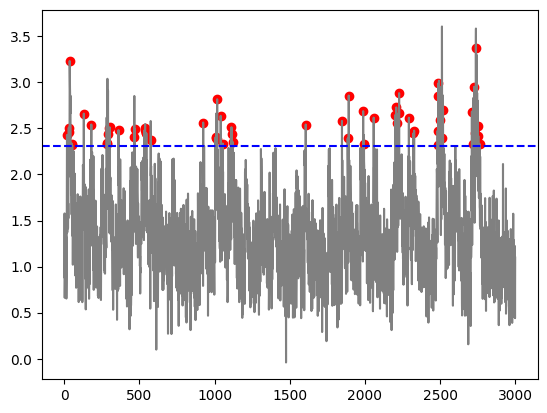

In [109]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_2, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_2))[onset_indices], fluorescence_trace_2[onset_indices], marker='o', color='r')

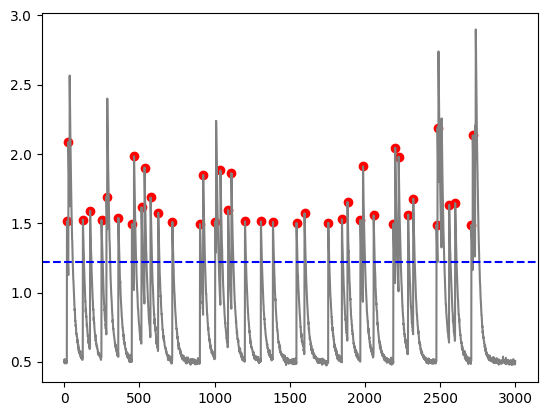

In [113]:
treshold_factor = 1.0
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_5, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_5))[onset_indices], fluorescence_trace_5[onset_indices], marker='o', color='r')

**Converting indices to timestamps**

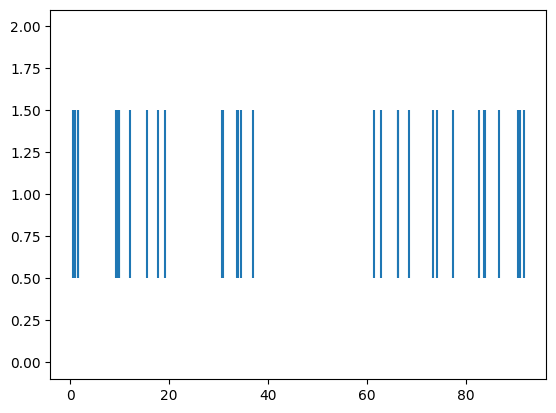

In [ ]:
frame_rate = 30 

treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

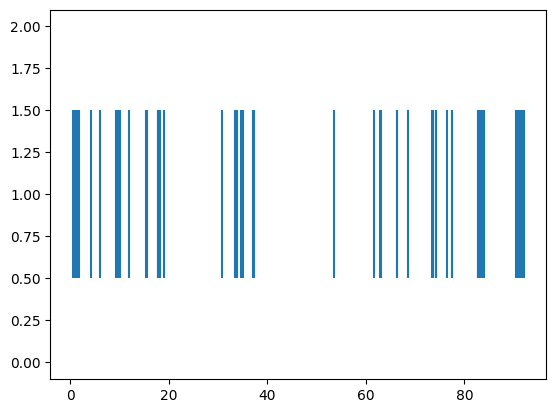

In [116]:
frame_rate = 30 

treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

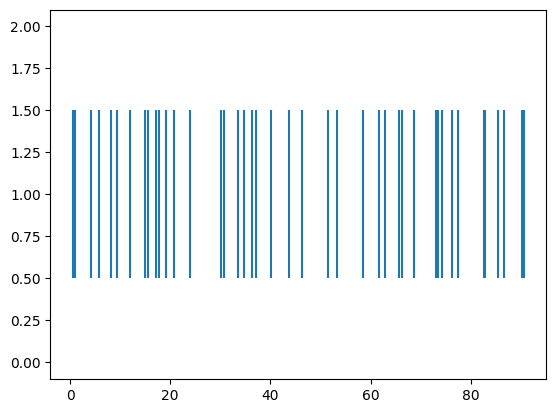

In [131]:
frame_rate = 30 

treshold_factor = 1.
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

**Comparison with groun-truth spikes**

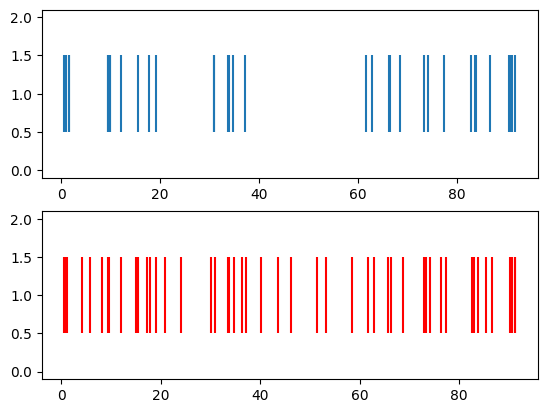

In [137]:
frame_rate = 30 

treshold_factor = 2.
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

true_spike_indices = np.where(spike_train_1 > 0)[0]

onset_times = onset_indices / frame_rate
true_spike_times = true_spike_indices / frame_rate

plt.subplot(211)
plt.eventplot(onset_times)

plt.subplot(212)
plt.eventplot(true_spike_times, color='r')

## Visualizing Spike Events on Top of the Deconvolved Trace

In this section, we will introduce a more advanced method for extracting spike events from calcium traces using the OASIS algorithm. OASIS fits a generative model of calcium dynamics to estimate the most likely times of neuronal firing, returning both spike amplitudes and deconvolved activity. This approach improves temporal resolution and accounts for the shape of calcium transients, making it particularly suitable for precise event detection in high-throughput datasets. You will learn how to apply the `deconvolve()` function from the `oasis` package and extract spike timings from its output.

#### Learning Goals:
- Install and import the OASIS package and load a calcium trace for analysis.
- Use the `deconvolve()` function to obtain spike train (`s`), denoised trace (`c`) (`b`).
- Extract non-zero entries from the spike train and convert them to timestamps and amplitudes.

**Extract spike trains**

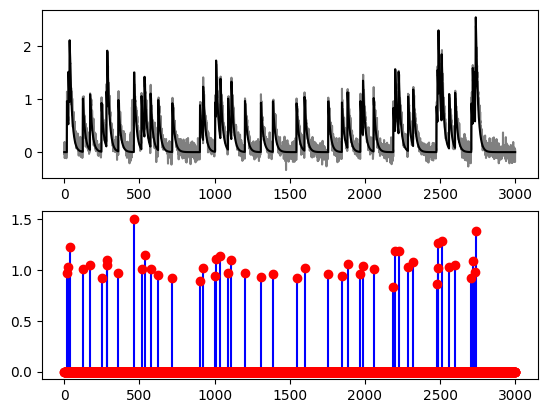

In [161]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')

plt.subplot(212)
plt.stem(range(len(spike_train)), spike_train, basefmt=" ", linefmt='b-', markerfmt='ro');

**Extract spike indices and amplitudes**

Find all time points where the inferred spike amplitude is greater than zero.

c:\Users\sangeetha\miniforge3\envs\calim\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


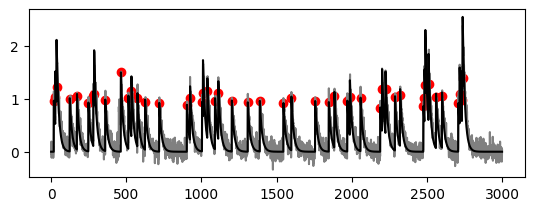

In [176]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

spike_indices = np.where(np.round(spike_train) > 0)[0]
spike_amplitudes = spike_train[spike_indices]

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')
plt.scatter(np.arange(len(spike_train))[spike_indices], spike_train[spike_indices], color='r')

## Estimating Firing Rate from Extracted Spike Times

The final step in this analysis is to convert spike times into a time-resolved firing rate. By binning the spike events into equally spaced time intervals and normalizing by bin width, we can compute the firing rate of each neuron across the recording. This representation is essential for many forms of downstream analysis, including population coding, condition comparisons, and temporal alignment with behavior.